In [72]:
from pathlib import Path
import napari
import tifffile
import numpy as np
from cellpose import models, utils
import skimage
from skimage import measure
from scipy.ndimage import binary_erosion

In [34]:
directory_path = Path("./test_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.lsm"):
    images.append(str(file_path))
    
images

['test_data\\DSB Iba1 20_40X_CA1_test.lsm',
 'test_data\\DSB Iba1 20_40X_DG_test.lsm',
 'test_data\\DSB Iba1 21_40X_DG_test2.lsm',
 'test_data\\DSB Iba1 33_40X_CA3.lsm',
 'test_data\\DSB Iba1 33_40X_DG.lsm',
 'test_data\\DSB Iba1 43_40X_CTX2.lsm',
 'test_data\\DSB Iba1 45_40X_CTX3.lsm',
 'test_data\\DSB Iba1 45_40X_DG.lsm',
 'test_data\\DSB Iba1 58_40X_CTX2.lsm',
 'test_data\\DSB Iba1 58_40X_CTX3.lsm']

In [35]:
viewer = napari.Viewer(ndisplay=2)
model = models.Cellpose(gpu=True, model_type='nuclei')

for image in images:
    
    # Extract filename
    file_path = Path(image)
    filename = file_path.stem

    # Read the image file 
    img = tifffile.imread(image)

    # Extract the stack containing the nuclei channel (0)
    nuclei_stack = img[:,0,:,:]
    dna_damage_stack = img[:,1,:,:]
    microglia_stack = img[:,2,:,:]

    # Perform maximum intensity projections
    nuclei_mip = np.max(nuclei_stack, axis=0)
    dna_damage_mip = np.max(dna_damage_stack, axis=0)
    microglia_mip = np.max(microglia_stack, axis=0)

    # Stack the arrays along a new axis (axis 0)
    stack = np.stack((nuclei_mip, dna_damage_mip, microglia_mip), axis=0)

    # Create a copy of nuclei_mip
    input_img = nuclei_mip.copy()

    # Might need to perform a Gaussian-blur before
    post_gaussian_img = skimage.filters.gaussian(input_img, sigma=6)

    # Predict nuclei masks using cellpose
    masks, flows, styles, diams = model.eval(post_gaussian_img, diameter=None, channels=[0, 0])

    # Show the resulting stack in Napari
    viewer.add_image(stack, name=f"{filename}_mip")
    viewer.add_image(nuclei_mip, name=f"{filename}_nuclei")
    viewer.add_labels(masks, name=f"{filename}_nuclei_mask")

Dev below

In [78]:
viewer = napari.Viewer(ndisplay=2)
model = models.Cellpose(gpu=True, model_type='nuclei')

image = images[0]

# Extract filename
file_path = Path(image)
filename = file_path.stem

# Read the image file 
img = tifffile.imread(image)

# Extract the stack containing the nuclei channel (0)
nuclei_stack = img[:,0,:,:]
dna_damage_stack = img[:,1,:,:]
microglia_stack = img[:,2,:,:]

# Perform maximum intensity projections
nuclei_mip = np.max(nuclei_stack, axis=0)
dna_damage_mip = np.max(dna_damage_stack, axis=0)
microglia_mip = np.max(microglia_stack, axis=0)

# Stack the arrays along a new axis (axis 0)
stack = np.stack((nuclei_mip, dna_damage_mip, microglia_mip), axis=0)

# Create a copy of nuclei_mip
input_img = nuclei_mip.copy()

# Might need to perform a Gaussian-blur before
post_gaussian_img = skimage.filters.gaussian(input_img, sigma=6)

# Predict nuclei masks using cellpose
masks, flows, styles, diams = model.eval(post_gaussian_img, diameter=None, channels=[0, 0], net_avg=False)

# Show the resulting stack in Napari
viewer.add_image(stack, name=f"{filename}_mip")
viewer.add_image(nuclei_mip, name=f"{filename}_nuclei")
viewer.add_labels(masks, name=f"{filename}_nuclei_mask")

# Set a threshold value for the pixels in microglia channel
threshold = 20  # Based on the microglia intensity

# Create a new array with the same shape as mask_array, initialized with False
result_array = np.full_like(masks, False, dtype=bool)

# Find indices where values in values_array are above the threshold
above_threshold_indices = microglia_mip > threshold


# Update the corresponding positions in the result_array based on the mask_array
masks = masks.astype(bool) # Make masks boolean to be able to use logical operators
result_array[masks & above_threshold_indices] = True

# Convert the boolean array to a binary array
binary_result_array = result_array.astype(int)

# Now, result_array contains True where both conditions are satisfied, and False otherwise
viewer.add_labels(binary_result_array, name=f"{filename}_nuclei+glia_coloc")

# Erode binary_result_array to get rid of small nuclei pixels colocalizing with glia branches
# Set the structuring element for erosion
structuring_element = np.ones((5, 5), dtype=bool)  # You can adjust the size and shape

# Perform binary erosion
eroded_array = binary_erosion(binary_result_array, structure=structuring_element)
viewer.add_labels(eroded_array, name=f"{filename}_nuclei+glia_coloc_pe")

# Now I want to recover just the masks that are sitting on top of binary_results_array
labels, num_labels = measure.label(masks, return_num=True)

# Create an array with the same shape as masks to store the processed regions
processed_regions = np.zeros_like(masks, dtype=bool)

# Create an array of indices corresponding to the True values in binary_result_array
true_indices = np.where(eroded_array)

# Iterate over each connected component
for label in range(1, num_labels + 1):
    # Extract the region corresponding to the current label
    region = (labels == label)

    # Check if any True value in binary_result_array is present in the region
    if np.any(region[true_indices]):
        # The entire connected component is sitting on top of True values
        # Store the processed region in the result array
        processed_regions |= region

viewer.add_labels(processed_regions, name=f"{filename}_glia+_nuclei_mask")

<Labels layer 'DSB Iba1 20_40X_CA1_test_glia+_nuclei_mask' at 0x1902eb298e0>

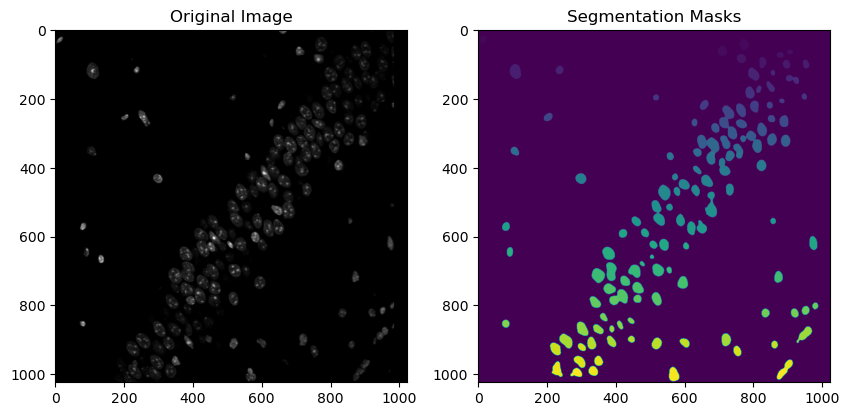

In [31]:
import matplotlib.pyplot as plt

# Visualize the original image and segmentation masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(masks, cmap='viridis')
plt.title('Segmentation Masks')

plt.show()

In [38]:
filtered_masks = masks

Checking the circumference of nuclei segmentation masks

In [39]:
import numpy as np
from skimage import measure

# Assuming 'filtered_masks' is your segmented masks array
labeled_masks = measure.label(filtered_masks)

# Measure properties of labeled objects
properties = measure.regionprops(labeled_masks)

# Extract diameters for each object
diameters = [prop.equivalent_diameter for prop in properties]

# Print or use the diameters as needed
for i, diameter in enumerate(diameters):
    print(f'Object {i+1}: Diameter = {diameter:.2f} pixels')

Object 1: Diameter = 21.23 pixels
Object 2: Diameter = 22.48 pixels
Object 3: Diameter = 30.63 pixels
Object 4: Diameter = 28.23 pixels
Object 5: Diameter = 15.14 pixels
Object 6: Diameter = 18.23 pixels
Object 7: Diameter = 26.84 pixels
Object 8: Diameter = 25.88 pixels
Object 9: Diameter = 23.45 pixels
Object 10: Diameter = 21.65 pixels
Object 11: Diameter = 37.56 pixels
Object 12: Diameter = 23.64 pixels
Object 13: Diameter = 33.40 pixels
Object 14: Diameter = 14.36 pixels
Object 15: Diameter = 19.58 pixels
Object 16: Diameter = 18.88 pixels
Object 17: Diameter = 23.88 pixels
Object 18: Diameter = 17.59 pixels
Object 19: Diameter = 30.40 pixels
Object 20: Diameter = 16.62 pixels
Object 21: Diameter = 17.30 pixels
Object 22: Diameter = 14.23 pixels
Object 23: Diameter = 25.78 pixels
Object 24: Diameter = 29.32 pixels
Object 25: Diameter = 18.54 pixels
Object 26: Diameter = 32.63 pixels
Object 27: Diameter = 35.18 pixels
Object 28: Diameter = 23.96 pixels
Object 29: Diameter = 21.14 p